In [1]:
import numpy as np
import pandas as pd
from matplotlib import cm
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
from scipy.spatial import KDTree
import networkx as nx


from model.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
threshol_set = {
    'x20' : {threshold: [20, 300], remove_no: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17]},
    'x13' : {threshold = [20, 700], remove_no = [0, 1, 2, 3, 4, 5, 6]},
    'x7' :  {threshold = [60, 700], remove_no = [9]},
}

In [2]:
# Read metadata
slide2file = {
    1 : '0011762',
    2 : '0011186',
    3 : '0011546',
    4 : '0011216',
    5 : '0011707',
    6 : '0011695',
    7 : '0011284',
    8 : '0011287',
}

with open("annotations/slides_patients_annotation.json", 'r') as file:
    slide_info = json.load(file)
sample_info = slide_info['sample_info']

with open("annotations/resolutions_hand_curated_v1.json", 'r') as file:
    resolutions = json.load(file)

In [3]:
# Read data: registered with harmony embedding
adata = sc.read_h5ad("/data/projects/robin/xenium_cgn/h5ad_aligned/merged_with_Disease.h5ad")

In [52]:
# Chose the slide and sample
slide = 1
sample = 7

# read DeepSPACE result
adata_gnn_i = sc.read_h5ad(f"adata/Result_slide_{slide}_sample_x{sample}.h5ad")

In [53]:
# Get the best resolution based on stability analysis
resolution_best = resolutions[f'x{sample}']
if resolution_best == None:
    print('No automated result has been found')
    print('"resolution_best" is empty')
else:
    print(f'"resolution_best" is {resolution_best}')

"resolution_best" is leiden_0.16


In [54]:
# Get glom cells
## Add cluster markers
adata_gnn_i = add_markers(adata_gnn_i, 
                          markers = KidneyCellMarkers, 
                          groupby = resolution_best,
                          colormap = colormap,
                          marker_subset = marker_subset, 
                          keyadded = 'final_clusters',
                          verbos = False
                         )
## Get glom locations
df_glom_i = adata_gnn_i.obs.loc[adata_gnn_i.obs['final_clusters'] == 'Glom. Podocytes', ['x', 'y']]

df_glom_i.head()

,x,y
cell_CRb53fa7cc5-3601,6938.232690,1806.894137
cell_CRb53fa7cc5-3625,6967.056253,1791.174384
cell_CRb53fa7cc5-3661,6951.927508,1815.749977
cell_CRb53fa7cc5-3667,6964.314996,1804.847987
cell_CRb53fa7cc5-3684,6959.312043,1807.044270


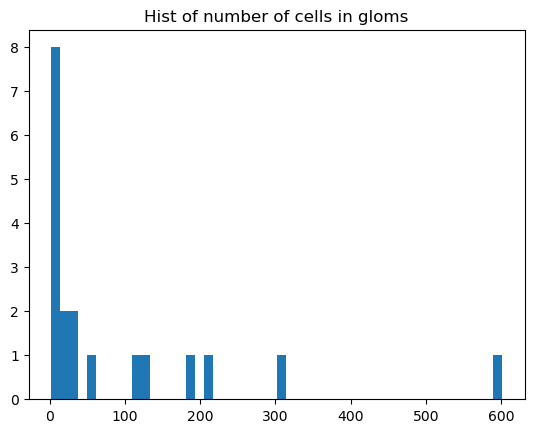

Text(0.5, 1.0, 'Isolated samples')

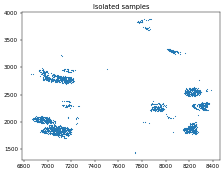

In [55]:
# Cluster gloms
## Make a distnace matrix via KDTree
coords = np.array(df_glom_i)
kdtree = KDTree(coords)
dist_mat = kdtree.sparse_distance_matrix(kdtree, max_distance=50)

## Convert into a "networkx" object
edge_index = np.array(dist_mat.nonzero())
G = nx.Graph()
G.add_edges_from(edge_index.T)

## Get connected components
cc = list(nx.connected_components(G))

## Plot hist for number of cells in gloms
sizes = np.array([len(c) for c in cc])
plt.hist(sizes, 50);
plt.title("Hist of number of cells in gloms")
plt.show()

# plot
dpi = 40
plt.figure(dpi=dpi)
plt.scatter(coords[:, 0], coords[:, 1], s=1, cmap="jet")
plt.title("Isolated samples")

In [74]:
# Set threshold
threshold = [60, 700]
remove_no = [9]

cc_filtered = [c for i, c in enumerate(cc) if (len(c) > threshold[0]) and (len(c) < threshold[1]) and (i not in remove_no)]

if len(cc_filtered) == 0:
    print('No glom remained')
else:
    print(f'Number of glomes remained = {len(cc_filtered)}')
    ## set glom numbers
    filtered_nodes = np.hstack([list(c) for c in cc_filtered])
    glom_number = []
    for i in filtered_nodes:
        for n, c in enumerate(cc_filtered):
            i_in_c = list(c).count(i) > 0
            if i_in_c:
                glom_number.append(n)
                break

Number of glomes remained = 5


In [75]:
# Make glom_adata "adata_glom" for sample i
X_glom = adata_gnn_i.X[adata_gnn_i.obs['final_clusters'] == 'Glom. Podocytes', :].copy()
adata_glom = sc.AnnData(X_glom)
adata_glom.var = adata_gnn_i.var
adata_glom.obs = adata_gnn_i.obs.loc[adata_gnn_i.obs['final_clusters'] == 'Glom. Podocytes', 
                              ['x', 'y', 'n_transcripts', 'final_clusters']]
adata_glom.obs['slide'] = slide
adata_glom.obs['sample'] = sample
adata_glom.obs['label'] = sample_info[f'slide_{slide}']['label'][f'x{sample}']
adata_glom = adata_glom[filtered_nodes,:]
adata_glom.obs['gnn_ann'] = 'glom'
adata_glom.obs['gnn_glom_no'] = glom_number

In [76]:
# Add to the adata
## restrict adata to adata_i
adata_i = adata[adata.obs['Sample_num'] == f'X{sample}'].copy()

## Add slide id to the rownames of gnn table
df_gnn_i = adata_glom.obs.copy()
gnn_glom_index = df_gnn_i.index
gnn_glom_index = gnn_glom_index + '_' + slide2file[slide]
df_gnn_i.index = gnn_glom_index
# df_gnn_i.head()

## Merge df_gnn_i to adata_i.obs
merged_df = adata_i.obs.merge(df_gnn_i[['gnn_ann', 'gnn_glom_no']], 
                              left_index=True, 
                              right_index=True,
                              how='left', 
                              suffixes=('', '_gnn'))
adata_i.obs.shape, merged_df.shape

((11001, 26), (11001, 28))

In [77]:
adata_i.obs = merged_df
adata_i.obs.head()

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,Disease,Slide_num,Sample_num,Slide_ID,celltype_l1,celltype_l1_codes,celltype_l1_proba,batch,gnn_ann,gnn_glom_no
cell_CRb53fa7cc5-17697_0011762,8277.831575,3103.807960,23.164366,2,20,1.6500,12.050,12.12,0.9965,0.9170,...,Sle,Slide1,X7,0011762,EC,24,0.739148,1,NaN,NaN
cell_CRb53fa7cc5-10254_0011762,7897.586725,2282.316022,26.751520,3,72,1.2800,2.060,56.26,0.9977,0.9361,...,Sle,Slide1,X7,0011762,podocyte,29,1.000000,1,glom,2.0
cell_CRb53fa7cc5-8237_0011762,7867.524279,1987.392538,28.381524,2,48,0.9748,3.643,49.24,0.9954,0.8979,...,Sle,Slide1,X7,0011762,CNT,2,0.589407,1,NaN,NaN
cell_CRb53fa7cc5-310051_0011762,8111.925757,2108.868927,26.985546,2,49,0.6456,1.384,75.90,0.9966,0.8257,...,Sle,Slide1,X7,0011762,PT,16,0.999617,1,NaN,NaN
cell_CRb53fa7cc5-3322_0011762,6902.500280,1740.039397,28.717231,2,30,0.5319,2.091,56.40,0.9954,0.8133,...,Sle,Slide1,X7,0011762,cycMNP,22,0.943821,1,NaN,NaN


In [79]:
# Plot
plot_HE = True

## add color
colormap = {'glom': '#0000FF40'}
adata_i.obs['gnn_ann'] = pd.Categorical(adata_i.obs['gnn_ann'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
adata_i.uns['gnn_ann_colors'] = list(colormap.values())

fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.spatial(adata_i,
              library_id=slide2file[slide],
              img_key='he_downscaled_aligned' if plot_HE else None,
              color='gnn_ann',
              size=0.5,
              ax=ax,
              show=False
             )
# plt.show()
# plt.savefig(f"glom_figs_final/slide_{slide}_sample_{sample}_gnn2.pdf", bbox_inches='tight')
# plt.close(fig)

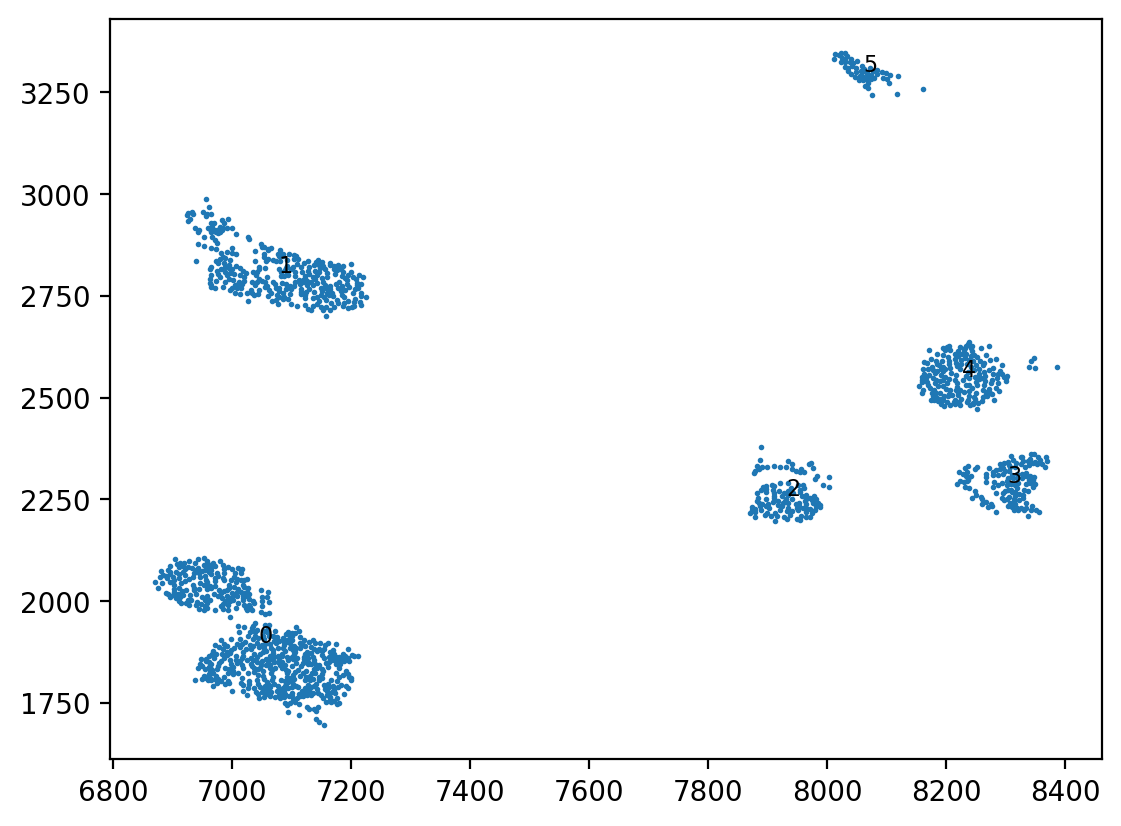

In [73]:
dpi = 200
plt.figure(dpi=dpi)
glom_mask = adata_i.obs['gnn_ann'] == 'glom'
plt.scatter(adata_i.obs.loc[glom_mask, 'x'], adata_i.obs.loc[glom_mask, 'y'], s=1)

for i in range(len(cc_filtered)):
    centroid = adata_i.obs.loc[adata_i.obs['gnn_glom_no'] == i, ['x', 'y']].mean()
    plt.text(centroid[0], centroid[1], f"{i}", fontsize=8)

In [26]:
print(ax.get_xlim())
print(ax.get_ylim())

(850.4392145454543, 4672.077694545455)
(15601.586351785718, 11907.3826125)


In [80]:
# adata_i.write(f"adata/Glom_GNN_Ann_slide_{slide}_sample_XX{sample}.h5ad")

In [70]:
# # Final check plot
# plot_HE = False

# adata_i = adata[adata.obs['Sample_num'] == f'X{sample}'].copy()
# ## add color
# colormap = {'glom': '#0000FF40'}
# adata_i.obs['gnn_ann'] = pd.Categorical(adata_i.obs['gnn_ann'], 
#                                        categories=list(colormap.keys()), 
#                                        ordered=True)
# adata_i.uns['gnn_ann_colors'] = list(colormap.values())

# fig, ax = plt.subplots(figsize=(10, 10))
# sc.pl.spatial(adata_i,
#               library_id=slide2file[slide],
#               img_key='he_downscaled_aligned' if plot_HE else None,
#               color='gnn_ann',
#               size=0.5,
#               ax=ax)
# plt.show()

In [42]:
# GNN-based annotation benefits
# time
# human eror
# HE image registration missmatch
# accurate boundries

## All in a loop

In [4]:
# Read data: registered with harmony embedding
adata = sc.read_h5ad("/data/projects/robin/xenium_cgn/h5ad_aligned/merged_with_Disease.h5ad")

In [6]:
threshold = [20, 700]

for slide in tqdm([1, 3, 4, 5, 6, 7, 8]):
    for sample, label in sample_info[f'slide_{slide}']['label'].items():

        sample = sample[1:3] # to remove the letter x at the beginning
        resolution_best = resolutions[f'x{sample}']
        if resolution_best == None:
            continue

        # read DeepSPACE result
        adata_gnn_i = sc.read_h5ad(f"adata/Result_slide_{slide}_sample_x{sample}.h5ad")


        # Get glom cells
        ## Add cluster markers
        adata_gnn_i = add_markers(adata_gnn_i, 
                                  markers = KidneyCellMarkers, 
                                  groupby = resolution_best,
                                  colormap = colormap,
                                  marker_subset = marker_subset, 
                                  keyadded = 'final_clusters',
                                  verbos = False
                                 )
        ## Get glom locations
        df_glom_i = adata_gnn_i.obs.loc[adata_gnn_i.obs['final_clusters'] == 'Glom. Podocytes', ['x', 'y']]

        # Cluster gloms
        ## Make a distnace matrix via KDTree
        coords = np.array(df_glom_i)
        kdtree = KDTree(coords)
        dist_mat = kdtree.sparse_distance_matrix(kdtree, max_distance=50)
        
        ## Convert into a "networkx" object
        edge_index = np.array(dist_mat.nonzero())
        G = nx.Graph()
        G.add_edges_from(edge_index.T)
        
        ## Get connected components
        cc = list(nx.connected_components(G))

        # Filter gloms
        ## Set filter
        remove_no = []
        cc_filtered = [c for i, c in enumerate(cc) if (len(c) > threshold[0]) and (len(c) < threshold[1]) and (i not in remove_no)]

        if len(cc_filtered) == 0:
            print('No glom remained')
            continue

        # print(f'Number of glomes remained = {len(cc_filtered)}')
        ## set glom numbers
        filtered_nodes = np.hstack([list(c) for c in cc_filtered])
        glom_number = []
        for i in filtered_nodes:
            for n, c in enumerate(cc_filtered):
                i_in_c = list(c).count(i) > 0
                if i_in_c:
                    glom_number.append(n)
                    break

        # Make glom_adata "adata_glom" for sample i
        X_glom = adata_gnn_i.X[adata_gnn_i.obs['final_clusters'] == 'Glom. Podocytes', :].copy()
        adata_glom = sc.AnnData(X_glom)
        adata_glom.var = adata_gnn_i.var
        adata_glom.obs = adata_gnn_i.obs.loc[adata_gnn_i.obs['final_clusters'] == 'Glom. Podocytes', 
                                      ['x', 'y', 'n_transcripts', 'final_clusters']]
        adata_glom.obs['slide'] = slide
        adata_glom.obs['sample'] = sample
        adata_glom.obs['label'] = sample_info[f'slide_{slide}']['label'][f'x{sample}']
        adata_glom = adata_glom[filtered_nodes,:]
        adata_glom.obs['gnn_ann'] = 'glom'
        adata_glom.obs['gnn_glom_no'] = glom_number

        # Add to the adata
        ## restrict adata to adata_i
        adata_i = adata[adata.obs['Sample_num'] == f'X{sample}'].copy()
        
        ## Add slide id to the rownames of gnn table
        df_gnn_i = adata_glom.obs.copy()
        gnn_glom_index = df_gnn_i.index
        gnn_glom_index = gnn_glom_index + '_' + slide2file[slide]
        df_gnn_i.index = gnn_glom_index
        # df_gnn_i.head()
        
        ## Merge df_gnn_i to adata_i.obs
        merged_df = adata_i.obs.merge(df_gnn_i[['gnn_ann', 'gnn_glom_no']], 
                                      left_index=True, 
                                      right_index=True,
                                      how='left', 
                                      suffixes=('', '_gnn'))
        # print(adata_i.obs.shape, merged_df.shape)
        adata_i.obs = merged_df

        # Save adata
        adata_i.write(f"adata/Glom_GNN_Ann_slide_{slide}_sample_X{sample}.h5ad")

        # Plot
        plot_HE = True
        
        ## add color
        colormap = {'glom': '#0000FF40'}
        adata_i.obs['gnn_ann'] = pd.Categorical(adata_i.obs['gnn_ann'], 
                                               categories=list(colormap.keys()), 
                                               ordered=True)
        adata_i.uns['gnn_ann_colors'] = list(colormap.values())
        
        fig, ax = plt.subplots(figsize=(10, 10))
        sc.pl.spatial(adata_i,
                      library_id=slide2file[slide],
                      img_key='he_downscaled_aligned' if plot_HE else None,
                      color='gnn_ann',
                      size=0.5,
                      ax=ax,
                      show=False)
        # plt.show()
        plt.savefig(f"glom_figs_final/slide_{slide}_sample_{sample}_gnn2.pdf", bbox_inches='tight')
        plt.close(fig)

100%|██████████| 7/7 [1:42:05<00:00, 875.06s/it] 


In [89]:
## Merge all adata_i into adata

# Read data: registered with harmony embedding
adata = sc.read_h5ad("/data/projects/robin/xenium_cgn/h5ad_aligned/merged_with_Disease.h5ad")

# Add empty cols to adata
adata.obs['gnn_ann'] = float('nan')
adata.obs['gnn_glom_no'] = float('nan')


In [91]:
for slide in tqdm([1, 3, 4, 5, 6, 7, 8]):
    for sample, label in sample_info[f'slide_{slide}']['label'].items():

        print(sample)
        sample = sample[1:3] # to remove the letter x at the beginning
        resolution_best = resolutions[f'x{sample}']
        if resolution_best == None:
            continue

        # read DeepSPACE annotation result
        adata_i = sc.read_h5ad(f"adata/Glom_GNN_Ann_slide_{slide}_sample_X{sample}.h5ad")

        adata.obs.loc[adata_i.obs.index, 'gnn_ann'] = adata_i.obs['gnn_ann']
        adata.obs.loc[adata_i.obs.index, 'gnn_glom_no'] = adata_i.obs['gnn_glom_no']

  0%|          | 0/7 [00:00<?, ?it/s]

x1
x2
x3
x4
x5
x6
x7
x8


 14%|█▍        | 1/7 [10:02<1:00:15, 602.62s/it]

x9
x10
x11
x12
x13
x14
x15
x16


 29%|██▊       | 2/7 [26:22<1:08:43, 824.78s/it]

x17
x18
x19
x20
x21
x22
x23
x24


 43%|████▎     | 3/7 [40:58<56:31, 847.93s/it]  

x25
x26
x27
x28
x29
x30
x31
x32


 57%|█████▋    | 4/7 [59:30<47:36, 952.13s/it]

x33
x34
x35
x36
x37
x38
x39
x40


 71%|███████▏  | 5/7 [1:15:53<32:06, 963.29s/it]

x41
x42
x43
x44
x45
x46
x47
x48


 86%|████████▌ | 6/7 [1:25:51<13:59, 839.05s/it]

x49
x50
x51
x52
x53
x54
x55
x56


100%|██████████| 7/7 [1:38:36<00:00, 845.18s/it]


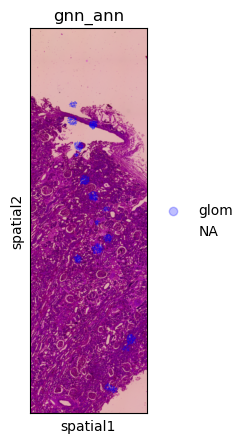

In [202]:
# Final check plot
plot_HE = True

sample = 9
slide = 58
adata_i = adata[adata.obs['Sample_num'] == f'X{sample}'].copy()

## add color
colormap = {'glom': '#0000FF40'}#, 'Other': '#1100040'}
adata_i.obs['gnn_ann'] = pd.Categorical(adata_i.obs['gnn_ann'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
adata_i.uns['gnn_ann_colors'] = list(colormap.values())

fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.spatial(adata_i,
              library_id='0018775', #slide2file[slide],
              img_key='he_downscaled_aligned' if plot_HE else None,
              color='gnn_ann',
              size=0.5,
              ax=ax)
plt.show()

In [190]:
adata_i = adata[adata.obs['Sample_num'] == f'X{57}']
(adata_i.obs['gnn_ann'] == 'glom').sum()

0

In [194]:
adata_i.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,Disease,Slide_num,Sample_num,Slide_ID,celltype_l1,celltype_l1_codes,celltype_l1_proba,batch,gnn_ann,gnn_glom_no
cell_CRe9244f5f0-274454_0018775,8973.079108,14275.671531,24.239919,2,162,1.3410,1.680,120.80,0.9969,0.9304,...,Anca,Slide9,X58,0018775,FIB,6,1.000000,0,NaN,Other
cell_CRe9244f5f0-241438_0018775,7611.762113,13482.074890,26.965581,1,86,1.3750,2.968,62.56,0.9971,0.9253,...,Anca,Slide9,X58,0018775,T,18,0.743161,0,NaN,Other
cell_CRe9244f5f0-229694_0018775,7905.179183,12544.214490,26.951706,2,52,1.3950,2.667,37.27,0.9949,0.8854,...,Anca,Slide9,X58,0018775,EC,5,0.999999,0,NaN,Other
cell_CRe9244f5f0-234433_0018775,8035.828453,12681.996247,26.722344,1,75,2.5130,2.896,29.85,0.9969,0.6803,...,Anca,Slide9,X58,0018775,MAC-M2,8,0.998505,0,NaN,Other
cell_CRe9244f5f0-211122_0018775,6807.297957,12159.132755,25.493740,2,49,0.8933,1.499,54.85,0.9959,0.9008,...,Anca,Slide9,X58,0018775,MAC-M2,8,0.999984,0,NaN,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CRe9244f5f0-241176_0018775,8614.366388,12468.879786,26.505110,2,147,1.0120,1.902,145.30,0.9962,0.9137,...,Anca,Slide9,X58,0018775,FIB,6,0.999999,0,NaN,Other
cell_CRe9244f5f0-211983_0018775,7746.670739,11308.402129,29.180936,3,155,1.2480,2.600,124.20,0.9970,0.9399,...,Anca,Slide9,X58,0018775,PT,16,0.997326,0,NaN,Other
cell_CRe9244f5f0-208910_0018775,7719.086376,10971.730716,26.632896,1,37,1.4040,4.121,26.36,0.9969,0.8400,...,Anca,Slide9,X58,0018775,MAC-M2,8,0.635204,0,NaN,Other
cell_CRe9244f5f0-210747_0018775,7953.782475,10963.609975,28.017054,2,40,1.0870,3.229,36.79,0.9969,0.7770,...,Anca,Slide9,X58,0018775,FIB,6,0.998079,0,NaN,Other


In [109]:
# adata.write("adata/Glom_GNN_Ann_all_2.h5ad")

In [99]:
adata.shape

(2899179, 480)

In [151]:
adata = sc.read_h5ad("adata/Glom_GNN_Ann_all_2.h5ad")

In [152]:
adata.obs['gnn_glom_no']

cell_CRc5a3721c5-120227_0011546    NaN
cell_CR85333614e-227363_0011284    NaN
cell_CRe9244f5f0-274454_0018775    NaN
cell_CRd921aadf4-7960_0011216      NaN
cell_CR85333614e-19040_0011284     NaN
                                  ... 
cell_CRb53fa7cc5-166196_0011762    NaN
cell_CRb53fa7cc5-152995_0011762    4.0
cell_CRb53fa7cc5-208012_0011762    NaN
cell_CRb53fa7cc5-211260_0011762    NaN
cell_CRb53fa7cc5-22467_0011762     NaN
Name: gnn_glom_no, Length: 2899179, dtype: float64

In [155]:
# adata.obs['gnn_ann'] = adata.obs['gnn_ann'].cat.add_categories('Other')
# adata.obs['gnn_ann'] = adata.obs['gnn_ann'].fillna('Other')

adata.obs['gnn_glom_no'] = adata.obs['gnn_glom_no'].astype('category')
adata.obs['gnn_glom_no'] = adata.obs['gnn_glom_no'].cat.add_categories('Other')
adata.obs['gnn_glom_no'] = adata.obs['gnn_glom_no'].fillna('Other')
adata.obs['gnn_glom_no'] = [int(i) if i!= 'Other' else 'Other' for i in adata.obs['gnn_glom_no']]
adata.obs['gnn_glom_no'] = adata.obs['gnn_glom_no'].astype(str).astype('category')
adata.obs['gnn_glom_no']

cell_CRc5a3721c5-120227_0011546    Other
cell_CR85333614e-227363_0011284    Other
cell_CRe9244f5f0-274454_0018775    Other
cell_CRd921aadf4-7960_0011216      Other
cell_CR85333614e-19040_0011284     Other
                                   ...  
cell_CRb53fa7cc5-166196_0011762    Other
cell_CRb53fa7cc5-152995_0011762        4
cell_CRb53fa7cc5-208012_0011762    Other
cell_CRb53fa7cc5-211260_0011762    Other
cell_CRb53fa7cc5-22467_0011762     Other
Name: gnn_glom_no, Length: 2899179, dtype: category
Categories (75, object): ['0', '1', '10', '11', ..., '73', '8', '9', 'Other']

In [156]:
adata.write("adata/Glom_GNN_Ann_all_4.h5ad")

In [116]:
adata2 = sc.read_h5ad("data_merged_with_gnn_glom.h5ad")

In [198]:
adata

AnnData object with n_obs × n_vars = 2899179 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'annot', 'annot_n', 'ID', 'Disease', 'Slide_num', 'Sample_num', 'Slide_ID', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_proba', 'batch', 'gnn_ann', 'gnn_glom_no'
    var: 'gene_ids', 'feature_types'
    uns: 'annot_colors', 'celltype_l1_colors', 'dendrogram_subclass.l1', 'gnn_ann_colors', 'log1p', 'spatial', 'subclass.l1_colors', 'wilcoxon'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    layers: 'counts'

In [199]:
adata.uns["spatial"].keys()

dict_keys(['0011216', '0011284', '0011287', '0011546', '0011695', '0011707', '0011762', '0018723', '0018775'])